# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 


* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, Constant, perform_experiments, ema_logging)
ema_logging.log_to_stderr(ema_logging.INFO)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import CLASSIFICATION, REGRESSION

def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

C:\Anaconda3\envs\py36_32\lib\site-packages\ema_workbench\em_framework\optimization.py:29: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Anaconda3\envs\py36_32\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Anaconda3\envs\py36_32\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
model = Model(name="PreyPred", function=PredPrey)

uncertainties = [
    RealParameter('prey_birth_rate',0.015,0.035),
    RealParameter('predation_rate',0.0005,0.003),
    RealParameter('predator_efficiency',0.001,0.004),
    RealParameter('predator_loss_rate',0.04,0.08),
]

outcomes = [
    TimeSeriesOutcome("TIME"),
    TimeSeriesOutcome("predators",),
    TimeSeriesOutcome("prey"),
]

constants = [
    Constant("final_time", 365),
    Constant("dt", 0.25)
]

model.uncertainties = uncertainties
model.outcomes = outcomes
model.constants = constants

In [6]:
n_scenarios = 1000
results = perform_experiments(models=model, scenarios=n_scenarios)

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


In [7]:
def result_df(result):
    df = pd.DataFrame()
    for i, key in enumerate(result[1].keys()):
        df[key] = result[1][key].flatten()
    n_exp = result[1][key].shape[0]
    t_steps = result[1][key].shape[-1]

    df["experiment"] = np.repeat(range(n_exp), t_steps)
    return df

def result_input(results):
    df_input = pd.DataFrame(index=list(results[0].dtype.names)[:5])
    for i in range(len(results[0])):
        df_input[i] = list(results[0][i])[:5]
    return df_input.T

df = result_df(results)
df_input = result_input(results)

In [8]:
df_input["final_prey"] = np.nan
final_prey = df[df["TIME"] == 365]["prey"].values
df_input["final_prey"] = final_prey

df_input["mu_prey"] = np.nan
df_input["std_prey"] = np.nan
for i in range(n_scenarios):
    mu_prey = df[df["experiment"] == i]["prey"].mean()
    df_input["mu_prey"].loc[i] = mu_prey
    
    std_prey = df[df["experiment"] == i]["prey"].std()
    df_input["std_prey"].loc[i] = std_prey

df_input.drop("scenario_id", axis = 1, inplace = True)

In [9]:
df_outcome = df_input.iloc[:, 4:]
df_input = df_input.iloc[:, :4]

In [10]:
df_input.head()

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate
0,0.000996,0.002169,0.077216,0.015504
1,0.000696,0.001885,0.051538,0.028572
2,0.000610,0.002949,0.049024,0.015929
3,0.002646,0.002170,0.057237,0.033881
4,0.001100,0.001555,0.059900,0.021220


In [11]:
df_outcome.head()

,final_prey,mu_prey,std_prey
0,51.476650,35.117299,9.451367
1,57.360196,27.965370,16.425398
2,3.140127,17.695539,15.870420
3,9.543268,25.626929,15.226986
4,49.759209,38.788878,7.769658


## Visualization of the data
    inputs: ['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']
    outcomes: ['final_prey', 'mu_prey', 'std_prey']

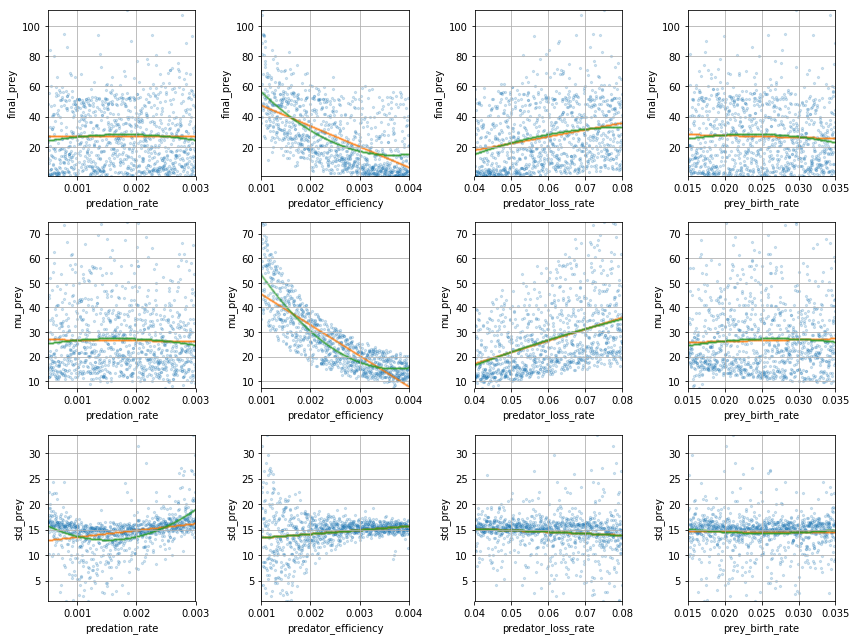

In [12]:
nrows = df_outcome.shape[1]
ncols = df_input.shape[1]

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                         figsize=(ncols*3, nrows*3))
locs = list(itertools.product(range(nrows), range(ncols)))
i = 0
for outcome_ in df_outcome:        
    for input_ in df_input:
        loc = locs[i]
        
        #specify x and y
        x = df_input[input_]
        y = df_outcome[outcome_]
        #scatter
        axes[loc].scatter(x, y, s=5, alpha=0.2)
        
        #regression fit (1st)
        fit = np.polyfit(x, y, deg=1)
        f = lambda x: fit[0]*x + fit[1]
        axes[loc].scatter(x, f(x),s=1, alpha=0.1)
        
        #regression fit (2nd)
        fit = np.polyfit(x, y, deg=2)
        f = lambda x: fit[0]*(x**2) + fit[1]*x + fit[2]
        axes[loc].scatter(x, f(x),s=1, alpha=0.1)
        
        #details for being pretty!
        axes[loc].set_xlabel(x.name)
        axes[loc].set_ylabel(y.name)
        axes[loc].set_xlim(x.min(), x.max())
        axes[loc].set_ylim(y.min(), y.max())
        axes[loc].grid()        
        i +=1
fig.tight_layout()

## 1. Fitting Regression Model

#### Check the inter-dependency between inputs
    (Obviously, they are independent in these generated data as they are independently sampled.)

C:\Anaconda3\envs\py36_32\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


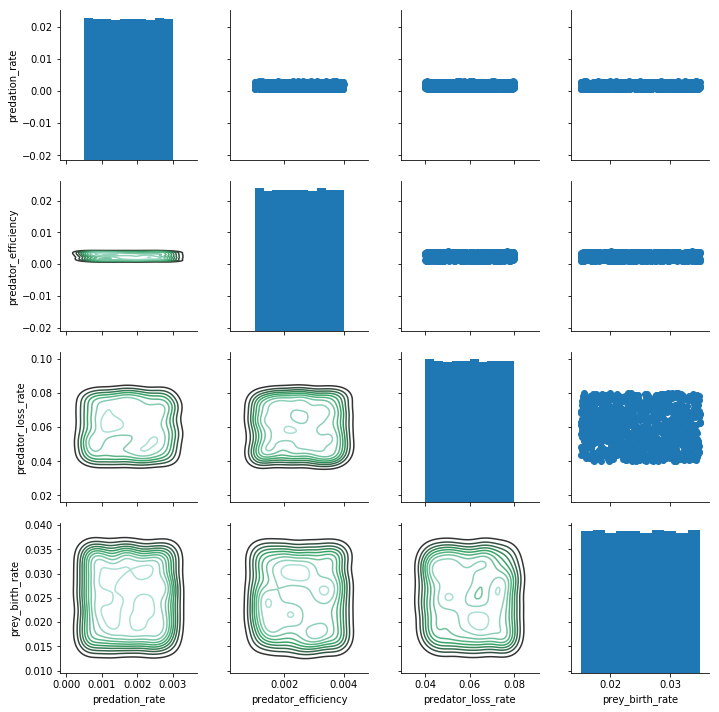

In [13]:
g = sns.PairGrid(df_input)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)

### Multiple Linear Regression Fitting for each outcome

In [14]:
import statsmodels.formula.api as smf
df = pd.concat(objs = [df_input, df_outcome], axis = 1)
for outcome in df_outcome:
    outcome_str = outcome
    formula_str = outcome_str + "~" + "+".join(df.columns[:4])
    lm = smf.ols(formula_str, data=df).fit()
    print(lm.summary())
    print("======================================")
    print("===============Boundary===============")
    print("======================================")

                            OLS Regression Results                            
Dep. Variable:             final_prey   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     169.7
Date:                Mon, 07 May 2018   Prob (F-statistic):          8.12e-111
Time:                        21:16:26   Log-Likelihood:                -4172.8
No. Observations:                1000   AIC:                             8356.
Df Residuals:                     995   BIC:                             8380.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              38.6420    

### Interpretation 1:
1. The variance of the outcome "<code>mu_prey</code>" is largely explained by 4 inputs (uncertainties), [<code>'predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate'</code>]
    R2: 0.874 (adj.R2:0.873)
2. Every p-value for each input shows substantially low figure, still the value of "<code>predation_rate</code>" is relatively high. (0.001) → We need to investigate the difference between the model with 4 inputs and 3 inputs. (the one without <code>predation_rate</code>)

#### 4 inputs

In [15]:
outcome_str = "mu_prey"
formula_str = outcome_str + "~" + "+".join(df.columns[:4])
lm1 = smf.ols(formula_str, data=df).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mu_prey   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     1686.
Date:                Mon, 07 May 2018   Prob (F-statistic):               0.00
Time:                        21:16:26   Log-Likelihood:                -2958.2
No. Observations:                1000   AIC:                             5926.
Df Residuals:                     995   BIC:                             5951.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              29.3247      1.199     24.452      0.000      26.971      31.678
predation_rate      -1142.4584    205.105     -5.570      0.000   -1544.947    -739.970
predator_efficiency -1.253e+04    170.914    -73.294      0.000   -1.29e+04   -1.22e+04
predator_loss_rate    464.6244     12.827     36.223      0.000     439.454     489.795
prey_birth_rate       110.5647     25.656      4.309      0.000      60.218     160.911
==============================================================================
Omnibus:                      244.932   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              532.680
Skew:                           1.356   Prob(JB):                    2.14e-116
Kurtosis:                       5.331   Cond. No.                     1.40e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Without <code>predation_rate</code>

In [16]:
formula_str = outcome_str + "~" + "+".join(df.columns[1:4])
lm2 = smf.ols(formula_str, data=df).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mu_prey   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     2173.
Date:                Mon, 07 May 2018   Prob (F-statistic):               0.00
Time:                        21:16:26   Log-Likelihood:                -2973.6
No. Observations:                1000   AIC:                             5955.
Df Residuals:                     996   BIC:                             5975.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              27.1500      1.151     23.590      0.000      24.892      29.408
predator_efficiency -1.247e+04    173.200    -72.019      0.000   -1.28e+04   -1.21e+04
predator_loss_rate    464.3334     13.018     35.667      0.000     438.787     489.880
prey_birth_rate       112.9525     26.036      4.338      0.000      61.860     164.045
==============================================================================
Omnibus:                      234.207   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              499.739
Skew:                           1.306   Prob(JB):                    3.04e-109
Kurtosis:                       5.275   Cond. No.                     1.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpretation 2:
1. The decrease of R2 is very tiny. (From 0.873->0.872)
2. It is likely to be fine to drop the less significant input, <code>predation_rate</code>

## 2. SALib

#### Brief Explanation about SALib.

    1. three inputs (x1/x2/x3) will be sampled.
    2. create y through some complicated function which takes three arguments, x1/x2/x3
    3. perform SA

For more information, please kindly visit: [SALib](http://salib.readthedocs.io/en/latest/basics.html#what-is-sensitivity-analysis)

In [75]:
import SALib

In [76]:
# Set Inputs' names and their Bounds
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}
problem

{'bounds': [[-3.14159265359, 3.14159265359],
  [-3.14159265359, 3.14159265359],
  [-3.14159265359, 3.14159265359]],
 'names': ['x1', 'x2', 'x3'],
 'num_vars': 3}

In [77]:
# Sampling
param_values = SALib.sample.saltelli.sample(problem = problem, N = 1000) #what is N?
param_values

array([[-1.76100994, -2.53413626,  0.11658254],
       [ 1.11060209, -2.53413626,  0.11658254],
       [-1.76100994, -1.38058271,  0.11658254],
       ...,
       [-0.05215535,  0.7025632 ,  1.48182544],
       [-0.05215535,  1.89906822, -2.29790322],
       [-0.05215535,  1.89906822,  1.48182544]])

In [78]:
# Check dimension
param_values.shape

(8000, 3)

In [79]:
print("SAMPLED value of x1:", param_values[:, 0])
print("SAMPLED value of x2:", param_values[:, 1])
print("SAMPLED value of x3:", param_values[:, 2])

SAMPLED value of x1: [-1.76100994  1.11060209 -1.76100994 ... -0.05215535 -0.05215535
 -0.05215535]
SAMPLED value of x2: [-2.53413626 -2.53413626 -1.38058271 ...  0.7025632   1.89906822
  1.89906822]
SAMPLED value of x3: [ 0.11658254  0.11658254  0.11658254 ...  1.48182544 -2.29790322
  1.48182544]


In [80]:
# create blank 8000 outputs
y = np.zeros(param_values.shape[0])

# create function
import math
func = lambda x1, x2, x3: math.sin(x1) + math.sin(x2)**2 + x3**4*math.sin(x1)

# calculate all 8000 ys
for i, param in enumerate(param_values):
    x1, x2, x3 = param
    x1 = math.radians(x1)
    x2 = math.radians(x2)
    x3 = math.radians(x3)
    y[i] = func(x1,x2,x3)
print(y)

[-0.02877565  0.02133738 -0.03015009 ... -0.00075993  0.0001879
  0.00018791]


In [87]:
# Analysis
Si = SALib.analyze.sobol.analyze(problem, Y = y)
print(np.round(Si["S1"], 3))
print(np.round(Si["ST"], 3))

[-0.193 -0.014  0.213  0.04 ]
[0.494 0.499 0.824 0.71 ]


#### Explanation ends

In [3]:
# Run Experiment (in EMA)
n_scenarios = 50

sa_results = perform_experiments(models = model, scenarios=n_scenarios, uncertainty_sampling=SOBOL)

# Split Inputs & Outcomes
experiments, outcomes = sa_results

[MainProcess/INFO] performing 500 scenarios * 1 policies * 1 model(s) = 500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] experiments finished


In [35]:
# mu_prey
outcome = outcomes["prey"].squeeze().mean(axis=1)

In [36]:
# Convert EMA's uncertainties into SALib's problem
problem = get_SALib_problem(model.uncertainties)

# Analyze
Si = sobol.analyze(problem, outcome,
                   calc_second_order=True, print_to_console=False)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}

print("N = %s"%n_scenarios)
print(pd.DataFrame(Si_filter, index=problem['names']))

N = 50
                           S1   S1_conf        ST   ST_conf
predation_rate      -0.005994  0.024320  0.003487  0.001756
predator_efficiency  0.797827  0.369886  0.924346  0.360821
predator_loss_rate   0.268775  0.218489  0.207882  0.116420
prey_birth_rate      0.007805  0.032460  0.007297  0.005185


### Interpretation:
    predator_efficiency: most important
    predator_loss_rate: 2nd most important

#### N= 250 and 1000

In [38]:
# Run Experiment (in EMA)
n_scenarios = 250

sa_results = perform_experiments(models = model, scenarios=n_scenarios, uncertainty_sampling=SOBOL)

# Split Inputs & Outcomes
experiments, outcomes = sa_results

# Convert EMA's uncertainties into SALib's problem
problem = get_SALib_problem(model.uncertainties)

# # Analyze
outcome = outcomes["prey"].squeeze().mean(axis=1)
Si = sobol.analyze(problem, outcome,
                   calc_second_order=True, print_to_console=False)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}

print("N = %s"%n_scenarios)
print(pd.DataFrame(Si_filter, index=problem['names']))

[MainProcess/INFO] performing 2500 scenarios * 1 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


N = 250
                           S1   S1_conf        ST   ST_conf
predation_rate      -0.002818  0.014654  0.005397  0.001793
predator_efficiency  0.757291  0.161688  0.865106  0.132263
predator_loss_rate   0.183267  0.086269  0.219949  0.043947
prey_birth_rate      0.017114  0.013876  0.009729  0.002390


In [39]:
# Run Experiment (in EMA)
n_scenarios = 1000

sa_results = perform_experiments(models = model, scenarios=n_scenarios, uncertainty_sampling=SOBOL)

# Split Inputs & Outcomes
experiments, outcomes = sa_results

# Convert EMA's uncertainties into SALib's problem
problem = get_SALib_problem(model.uncertainties)

# Analyze
outcome = outcomes["prey"].squeeze().mean(axis=1)
Si = sobol.analyze(problem, outcome,
                   calc_second_order=True, print_to_console=False)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}

print("N = %s"%n_scenarios)
print(pd.DataFrame(Si_filter, index=problem['names']))

[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


N = 1000
                           S1   S1_conf        ST   ST_conf
predation_rate       0.001691  0.006683  0.005197  0.000888
predator_efficiency  0.769440  0.085482  0.817172  0.068369
predator_loss_rate   0.179886  0.038935  0.218995  0.027205
prey_birth_rate      0.002274  0.010041  0.011610  0.001606


In [40]:
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

In [41]:
Si_df

,S1,S1_conf,ST,ST_conf
predation_rate,0.001691,0.006683,0.005197,0.000888
predator_efficiency,0.769440,0.085482,0.817172,0.068369
predator_loss_rate,0.179886,0.038935,0.218995,0.027205
prey_birth_rate,0.002274,0.010041,0.011610,0.001606


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

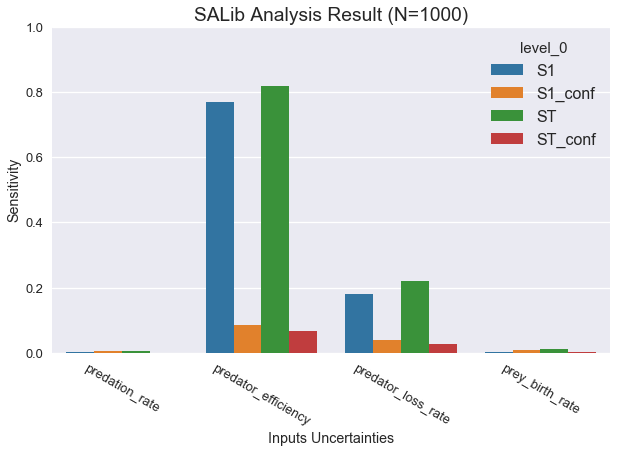

In [80]:
fig, ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.set_context("poster")
sns.barplot(x="level_1", y=0, data = Si_df.T.stack().reset_index(), hue="level_0", ax=ax)
ax.set_xlabel("Inputs Uncertainties")
ax.set_ylim(0,1)
ax.set_ylabel("Sensitivity")
ax.set_title("SALib Analysis Result (N=1000)")
plt.xticks(rotation=-30)

### Scenario Discovery where <code>mu_prey</code> is larger than 40

In [85]:
from ema_workbench.analysis import prim
x = experiments
y = outcome > 40
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 1590 cases of interest
[MainProcess/INFO] mean: 0.9986486486486487, mass: 0.074, coverage: 0.4647798742138365, density: 0.9986486486486487 restricted_dimensions: 3


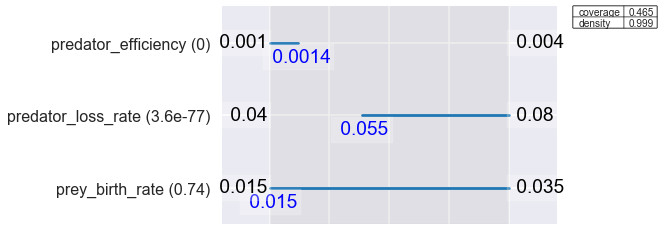

In [87]:
box1.inspect(style='graph')
plt.show()

## 3. Extra-Trees analysis